In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.8.2'

In [2]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
network.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [3]:
len(network.layers)

22

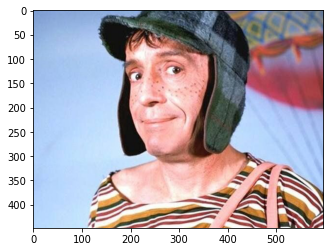

In [11]:
imagem_conteudo = tf.keras.preprocessing.image.load_img('chaves.jpeg')
plt.imshow(imagem_conteudo);

In [12]:
type(imagem_conteudo)

PIL.JpegImagePlugin.JpegImageFile

In [13]:
# PIL -> Array 
imagem_conteudo = tf.keras.preprocessing.image.img_to_array(imagem_conteudo)

In [14]:
imagem_conteudo = imagem_conteudo / 255
imagem_conteudo

array([[[0.47843137, 0.6039216 , 0.8039216 ],
        [0.47843137, 0.6039216 , 0.8039216 ],
        [0.47843137, 0.6039216 , 0.8039216 ],
        ...,
        [0.38039216, 0.4627451 , 0.54509807],
        [0.38039216, 0.4627451 , 0.54509807],
        [0.38039216, 0.4627451 , 0.54509807]],

       [[0.4862745 , 0.6117647 , 0.8117647 ],
        [0.4862745 , 0.6117647 , 0.8117647 ],
        [0.4862745 , 0.6117647 , 0.8117647 ],
        ...,
        [0.3882353 , 0.46666667, 0.56078434],
        [0.3882353 , 0.46666667, 0.56078434],
        [0.3882353 , 0.46666667, 0.56078434]],

       [[0.49019608, 0.6156863 , 0.8156863 ],
        [0.49019608, 0.6156863 , 0.8156863 ],
        [0.49019608, 0.6156863 , 0.8156863 ],
        ...,
        [0.39215687, 0.47058824, 0.5686275 ],
        [0.39215687, 0.47058824, 0.5686275 ],
        [0.39215687, 0.47058824, 0.5686275 ]],

       ...,

       [[0.7294118 , 0.8627451 , 1.        ],
        [0.7254902 , 0.85882354, 1.        ],
        [0.7254902 , 0

In [15]:
imagem_conteudo.shape

(448, 598, 3)

In [16]:
imagem_conteudo = imagem_conteudo[tf.newaxis, :]
imagem_conteudo.shape

(1, 448, 598, 3)

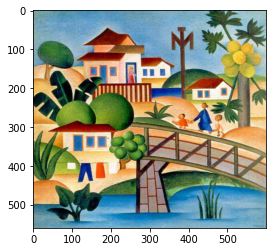

In [20]:
imagem_estilo = tf.keras.preprocessing.image.load_img('tarsila_amaral.jpg')
plt.imshow(imagem_estilo)

In [22]:
imagem_estilo = tf.keras.preprocessing.image.img_to_array(imagem_estilo)
imagem_estilo = imagem_estilo / 255
imagem_estilo = imagem_estilo[tf.newaxis, :]
imagem_estilo.shape

(1, 560, 600, 3)

In [25]:
camadas_conteudo = ['block4_conv2']
camadas_estilo = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [26]:
numero_camadas_conteudo = len(camadas_conteudo)
numero_camadas_estilo = len(camadas_estilo)
print(numero_camadas_conteudo, numero_camadas_estilo)

1 5


In [27]:
for nome in camadas_estilo:
  print(nome)

block1_conv1
block2_conv1
block3_conv1
block4_conv1
block5_conv1


In [28]:
def vgg_camadas(nome_camadas):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(nome).output for nome in nome_camadas]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)
  return network

extrator_estilo = vgg_camadas(camadas_estilo)
extrator_estilo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [29]:
saidas_estilo = extrator_estilo(imagem_estilo)

In [30]:
saidas_estilo[1].shape

TensorShape([1, 280, 300, 128])

In [31]:
saidas_estilo[0].shape, saidas_estilo[1].shape, saidas_estilo[2].shape, saidas_estilo[3].shape, saidas_estilo[4].shape,  

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [33]:
def gram_matrix(ativacoes):
  resultado = tf.linalg.einsum('bijc,bijd->bcd', ativacoes, ativacoes)
  input_shape = tf.shape(ativacoes)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return resultado / num_locations

In [34]:
saidas_estilo[0]

<tf.Tensor: shape=(1, 560, 600, 64), dtype=float32, numpy=
array([[[[0.0000000e+00, 1.1168056e-01, 6.2121809e-02, ...,
          4.7374946e-01, 4.9520522e-01, 1.5619564e-01],
         [0.0000000e+00, 2.1199909e-01, 3.7911364e-01, ...,
          1.7614037e-01, 1.4901578e+00, 1.1453360e+00],
         [0.0000000e+00, 2.0160642e-01, 3.8564062e-01, ...,
          1.3608325e-01, 1.5308917e+00, 1.1796422e+00],
         ...,
         [0.0000000e+00, 3.3286181e-01, 5.1675826e-01, ...,
          0.0000000e+00, 1.6993666e+00, 1.3342988e+00],
         [0.0000000e+00, 3.4320116e-01, 5.2286661e-01, ...,
          0.0000000e+00, 1.7050551e+00, 1.3393183e+00],
         [7.8187567e-01, 4.2259818e-01, 7.7565944e-01, ...,
          4.4906515e-01, 2.4665630e+00, 2.3771269e+00]],

        [[0.0000000e+00, 1.1404040e-01, 0.0000000e+00, ...,
          7.9952955e-02, 0.0000000e+00, 0.0000000e+00],
         [6.3841367e-01, 2.4004281e-01, 3.5869697e-01, ...,
          0.0000000e+00, 5.8317912e-01, 7.0515585e-01

In [35]:
gram_matrix(saidas_estilo[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6311029 , 0.2894989 , 0.28517216, ..., 0.10518257,
         0.36955732, 0.45017174],
        [0.2894989 , 0.24226913, 0.18415499, ..., 0.03151667,
         0.19604628, 0.21700144],
        [0.28517216, 0.18415499, 0.16761069, ..., 0.02775798,
         0.19407696, 0.22697598],
        ...,
        [0.10518257, 0.03151667, 0.02775798, ..., 0.08261996,
         0.06934635, 0.06635   ],
        [0.36955732, 0.19604628, 0.19407696, ..., 0.06934635,
         0.2869287 , 0.3186244 ],
        [0.45017174, 0.21700144, 0.22697598, ..., 0.06635   ,
         0.3186244 , 0.37485752]]], dtype=float32)>

In [38]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, camadas_estilo, camadas_conteudo):
    super().__init__()
    self.vgg = vgg_camadas(camadas_estilo + camadas_conteudo)
    self.camadas_estilo = camadas_estilo
    self.camadas_conteudo = camadas_conteudo
    self.numero_camadas_estilo = len(camadas_estilo)
    self.vgg.trainable = False

  def call(self, imagem):
    imagem = imagem * 255.0
    # 0 - 1
    # -127.50 - 127.50
    imagem_preprocessada = tf.keras.applications.vgg19.preprocess_input(imagem)
    outputs = self.vgg(imagem_preprocessada)
    saidas_estilo = outputs[:self.numero_camadas_estilo] # 0-4
    saidas_conteudo = outputs[self.numero_camadas_estilo:] # 5:

    saidas_estilo = [gram_matrix(camada) for camada in saidas_estilo]

    conteudo_dict = {nome_conteudo: valor for nome_conteudo, valor in zip(self.camadas_conteudo, saidas_conteudo)}
    estilo_dict = {nome_estilo: valor for nome_estilo, valor in zip(self.camadas_estilo, saidas_estilo)}

    return {'conteudo': conteudo_dict, 'estilo': estilo_dict}

In [39]:
camadas_estilo, camadas_conteudo

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [40]:
extrator = StyleContentModel(camadas_estilo, camadas_conteudo)
resultados = extrator(imagem_conteudo)
resultados

{'conteudo': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.105839,    0.      ,    0.      , ...,  574.59796 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  291.41885 ,
             132.35033 ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  332.05222 ,
             118.952034,    0.      ],
           ...,
           [ 700.125   ,    0.      ,    0.      , ..., 1511.4629  ,
              11.206578,  325.4834  ],
           [ 141.86774 ,    0.      ,    0.      , ..., 1099.7539  ,
              96.57442 ,  195.72563 ],
           [ 137.43665 ,    0.      ,    0.      , ...,  469.2027  ,
             180.22139 ,  676.20026 ]],
  
          [[   0.      ,    0.      ,    0.      , ...,  549.103   ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,   44.16062 ,
               0.      ,    0.      ],
           [   0.      ,    

In [41]:
for chave, valor in resultados.items():
  print(chave, valor.keys())

conteudo dict_keys(['block4_conv2'])
estilo dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [42]:
estilo_objetivo = extrator(imagem_estilo)['estilo']
conteudo_objetivo = extrator(imagem_conteudo)['conteudo']

In [43]:
len(estilo_objetivo), len(conteudo_objetivo)

(5, 1)

In [44]:
nova_imagem = tf.Variable(imagem_conteudo)

In [45]:
peso_conteudo = 1
peso_estilo = 1000

In [46]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

# Training

In [47]:
precos_reais = np.array([10000, 15000])
previsoes = np.array([8000, 15900])

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(precos_reais, previsoes)

1450.0

In [49]:
mean_squared_error(precos_reais, previsoes)

2405000.0

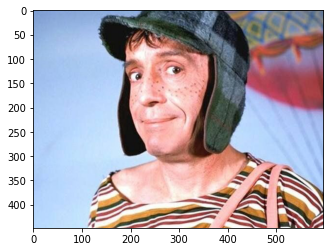

In [50]:
plt.imshow(tf.squeeze(imagem_conteudo, axis=0));

Época:  500  Conteúdo loss:  tf.Tensor(621789.2, shape=(), dtype=float32)  Estilo loss:  tf.Tensor(139673020.0, shape=(), dtype=float32)  Total loss:  tf.Tensor(27935228000.0, shape=(), dtype=float32)


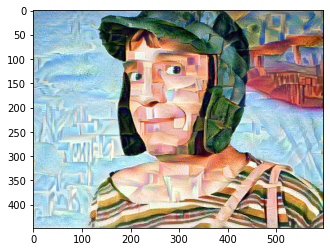

Época:  1000  Conteúdo loss:  tf.Tensor(653045.44, shape=(), dtype=float32)  Estilo loss:  tf.Tensor(100958856.0, shape=(), dtype=float32)  Total loss:  tf.Tensor(20192424000.0, shape=(), dtype=float32)


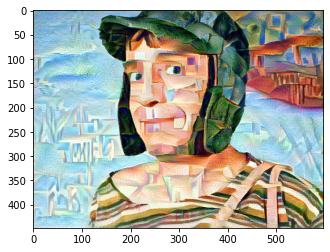

Época:  1500  Conteúdo loss:  tf.Tensor(672169.7, shape=(), dtype=float32)  Estilo loss:  tf.Tensor(73750860.0, shape=(), dtype=float32)  Total loss:  tf.Tensor(14750845000.0, shape=(), dtype=float32)


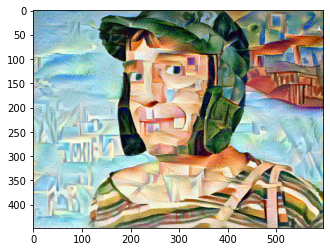

Época:  2000  Conteúdo loss:  tf.Tensor(688326.94, shape=(), dtype=float32)  Estilo loss:  tf.Tensor(159555760.0, shape=(), dtype=float32)  Total loss:  tf.Tensor(31911842000.0, shape=(), dtype=float32)


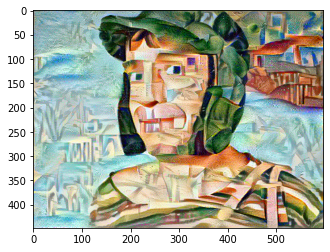

Época:  2500  Conteúdo loss:  tf.Tensor(707057.9, shape=(), dtype=float32)  Estilo loss:  tf.Tensor(124973860.0, shape=(), dtype=float32)  Total loss:  tf.Tensor(24995478000.0, shape=(), dtype=float32)


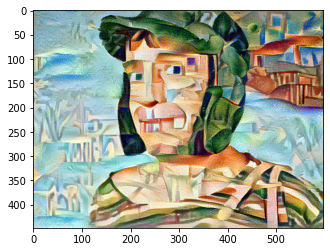

Época:  3000  Conteúdo loss:  tf.Tensor(707949.3, shape=(), dtype=float32)  Estilo loss:  tf.Tensor(122984136.0, shape=(), dtype=float32)  Total loss:  tf.Tensor(24597537000.0, shape=(), dtype=float32)


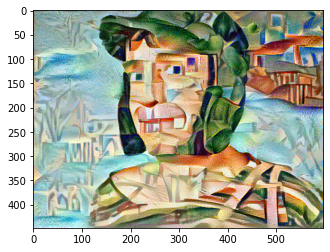

In [51]:
epocas = 3000
impressao = 500

for epoca in range(epocas):
  with tf.GradientTape() as tape:
    outputs = extrator(nova_imagem)

    saidas_conteudo = outputs['conteudo']
    saidas_estilo = outputs['estilo']

    conteudo_loss = tf.add_n([tf.reduce_mean((saidas_conteudo[nome] - conteudo_objetivo[nome]) ** 2) for nome in saidas_conteudo.keys()])
    estilo_loss = tf.add_n([tf.reduce_mean((saidas_estilo[nome] - estilo_objetivo[nome]) ** 2) for nome in saidas_estilo.keys()])
    total_loss = conteudo_loss * peso_conteudo / numero_camadas_conteudo + estilo_loss * peso_estilo / numero_camadas_estilo

  gradiente = tape.gradient(total_loss, nova_imagem)
  optimizer.apply_gradients([(gradiente, nova_imagem)])
  nova_imagem.assign(tf.clip_by_value(nova_imagem, 0.0, 1.0))

  if (epoca + 1) % impressao == 0:
    print('Época: ', epoca + 1, ' Conteúdo loss: ', conteudo_loss, ' Estilo loss: ', estilo_loss, ' Total loss: ', total_loss)
    plt.imshow(tf.squeeze(nova_imagem, axis=0));
    plt.show()

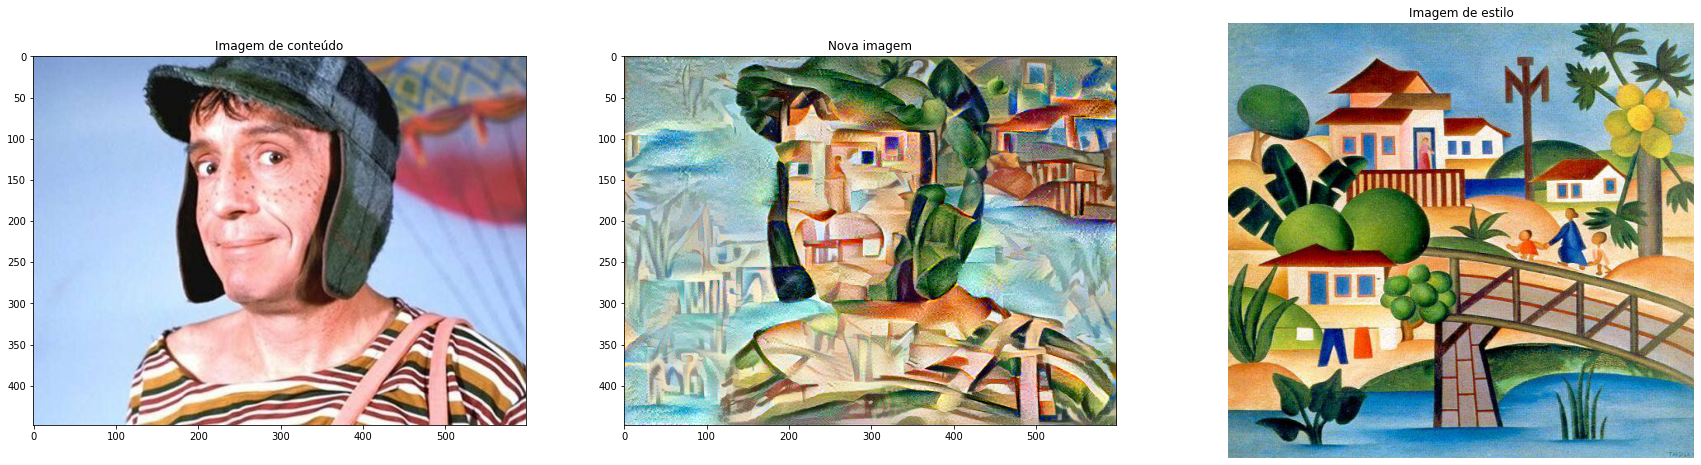

In [52]:
figura, (eixo1, eixo2, eixo3) = plt.subplots(1, 3, figsize=(30,8))
eixo1.imshow(tf.squeeze(imagem_conteudo, axis = 0))
eixo1.set_title('Imagem de conteúdo')
plt.axis('off')
eixo2.imshow(tf.squeeze(nova_imagem, axis = 0))
eixo2.set_title('Nova imagem')
plt.axis('off')
eixo3.imshow(tf.squeeze(imagem_estilo, axis = 0))
eixo3.set_title('Imagem de estilo')
plt.axis('off');